先从简单的帖子开始吧：https://blog.csdn.net/liuxoxo/article/details/85218135
    关于Python的ARCH包（二）

In [44]:
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
from arch import arch_model
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/flu16/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['subplot']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


这里先把sp500的数据给下载下来，然后变成percent change

In [45]:
start = dt.datetime(2000, 1, 1)
end = dt.datetime(2019, 4, 1)
sp500 = web.DataReader('^GSPC', 'yahoo', start=start, end=end)
# 利用pct_change()把adjust colse price 变成percent change,然后把空值去掉（其实应该只有第一个值是NaN）
pct_change_data = sp500['Adj Close'].pct_change().dropna() 

在变成GARCH模型之前，我们先画一些图，来证明数据符合ARCH模型的特性（如果忘了哪五条特性，回去看下书）

（1）首先，我们画下这个pct_change的数据长什么样子
    (既然是pandas数据，那我就直接用pandas的plot了，就不调用matplotlib的plot了)

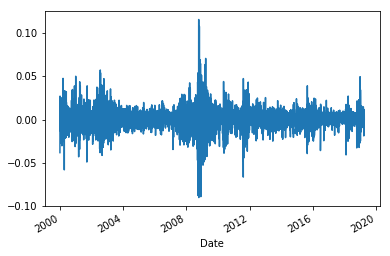

In [46]:
pct_change_data.plot()

            很明显，他的波动率呈现周期性

（2）然后我们看下returns 是否自相关，于是我们要画pct_change 的ACF图
        （这里就要用到statsmodels.api 和statsmodels.tsa.api了）

In [47]:
import statsmodels.tsa.api as smt

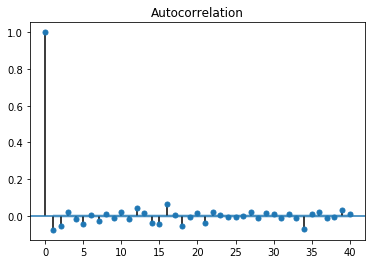

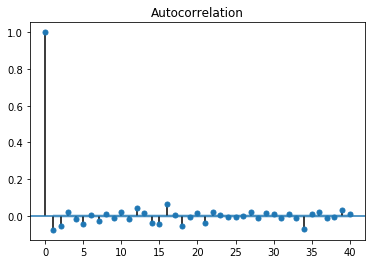

In [48]:
smt.graphics.plot_acf(pct_change_data, lags=40, alpha=0.5)

            (2.2)关于这个包的导入，有几种玩法，那我这里写下其他一种方法，效果是一样的：

                import statsmodels.api as sm

                def acf_pacf_plot(ts_log_diff):

                sm.graphics.tsa.plot_acf(ts_log_diff,lags=40) #ARIMA,q
                sm.graphics.tsa.plot_pacf(ts_log_diff,lags=40) #ARIMA,p


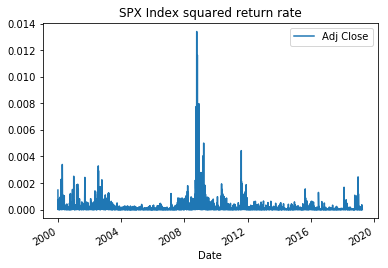

In [49]:
pd.DataFrame(pct_change_data**2).plot(title='SPX Index squared return rate')

（3）然后我们来看下return 的 平方 的自相关性，也就return平方的ACF

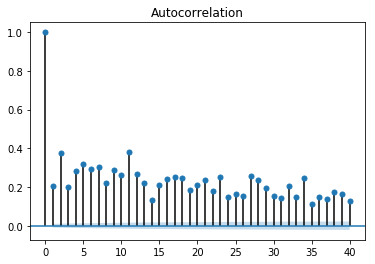

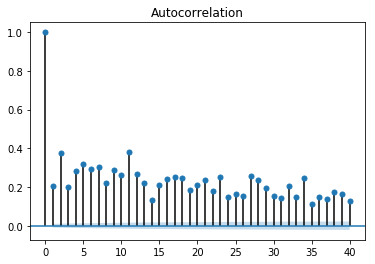

In [50]:
smt.graphics.plot_acf(pct_change_data**2, lags=40, alpha=0.5)

        不错，不错，它们还是有关系的

网上有的例子里面求了PACF这里说下原因：
    偏自相关系数PACF：
为什么需要偏自相关系数？
在AR(1)模型中，即使y(t-2)没有直接出现在模型中，但是y(t)和y(t-2)之间也相关，
偏相关系数是在排除了其他变量的影响之后两个变量之间的相关系数。

所以我们需要偏自相关系数。
y(t)和y(t-s)的偏自相关系数，排除了插入值y(t-1)到y(t-s+1)间的影响

这部分解释见：https://www.cnblogs.com/xuanlvshu/p/5410721.html

（4）既然网上画pacf那我也来画一下好了

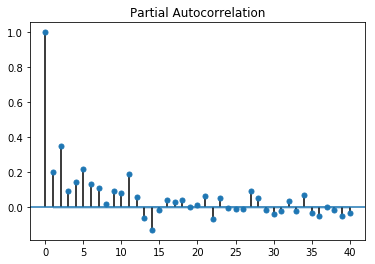

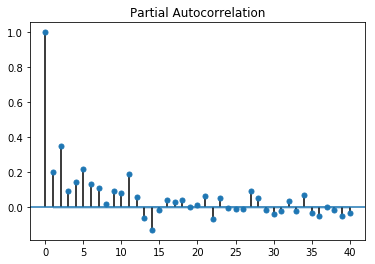

In [51]:
smt.graphics.plot_pacf(pct_change_data**2, lags=40, alpha=0.5)

这个要如何解释?不管了，之后再找下资料就行了，或者不写在报告里面，这个不重要的

可以结合momentum来解释

这里说下pacf的意义：就是在给定一段时期中间的数据，在已知这个的情况下，求首尾时期的acf，这个就是pacf了,这是为了防止每个时期互相影响

下面开始使用arch包，进行拟合

In [63]:
am = arch_model(pct_change_data)
res=am.fit() #拟合
res.summary#拟合结果

Iteration:      1,   Func. Count:      6,   Neg. LLF: -15660.033602147985
Iteration:      2,   Func. Count:     22,   Neg. LLF: -15664.743787033658
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -15664.74381263924
            Iterations: 6
            Function evaluations: 22
            Gradient evaluations: 2


/Users/flu16/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


<bound method ARCHModelResult.summary of                      Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:                15664.7
Distribution:                  Normal   AIC:                          -31321.5
Method:            Maximum Likelihood   BIC:                          -31295.5
                                        No. Observations:                 4841
Date:                Sun, Apr 28 2019   Df Residuals:                     4837
Time:                        17:08:27   Df Model:                            4
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         5.7069

这里让我回顾先GARCH的模型

In [53]:
from IPython.display import Image
Image(url= "https://img-blog.csdnimg.cn/20181222213115632.png")

In [54]:
res.conf_int()

,lower,upper
mu,0.000364,0.000777
omega,0.000003,0.000003
alpha[1],0.083072,0.116928
beta[1],0.869136,0.890864


对于拟合的结果我们可以进行哪些操作：

    summary() [source] :对结果进行汇总。

    plot() ：对波动率和标准化的残差进行绘图。

    conf_int()[source] ：置信区间。

    loglikelihood ：浮点型，对数似然率的值。

    params ：时间序列类型，估计所得参数。

    param_cov ：DataFrame类型，估计参数的方差协方差。

    resid ：{ndarray, Series}：观察值数组，包括模型残差。

In [55]:
res.params

mu          0.000571
omega       0.000003
alpha[1]    0.100000
beta[1]     0.880000
Name: params, dtype: float64

In [56]:
res.forecast

<bound method ARCHModelFixedResult.forecast of                      Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:                15664.7
Distribution:                  Normal   AIC:                          -31321.5
Method:            Maximum Likelihood   BIC:                          -31295.5
                                        No. Observations:                 4841
Date:                Sun, Apr 28 2019   Df Residuals:                     4837
Time:                        15:46:29   Df Model:                            4
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         

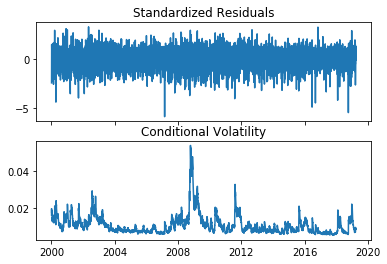

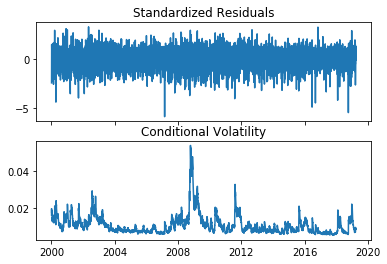

In [57]:
res.plot()

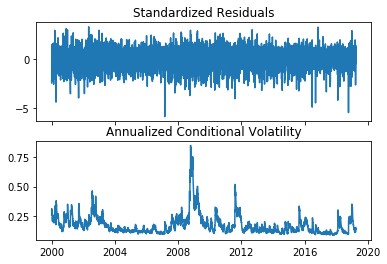

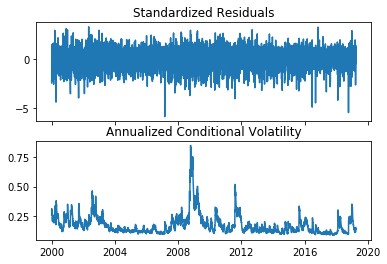

In [58]:
res.plot(annualize='D') #年化波动率图

　　【年化波动率的计算方法】

　　衡量某个指数、基金或投资组合的风险的指标有很多，年化波动率是其中比较常用的一个。年化波动率的算法也有很多种，这里我们介绍万得（Wind）的算法，这也是最常用的一种。

　　（1）年化波动率=收益率标准差*(n^0.5)。

　　其中：计算周期为日，对应n为250；计算周期为周，对应n为52；计算周期为月，对应n为12；计算周期为年，对应n为1。

In [59]:
fixed_res = am.fix([0.052489,0.015603,0.087837,0.901395])

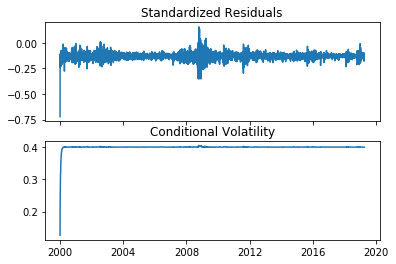

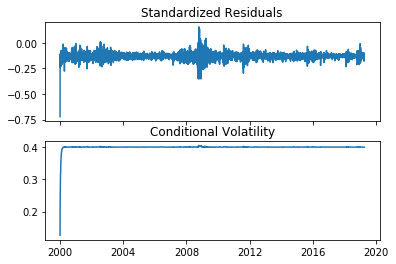

In [60]:
fixed_res.plot()

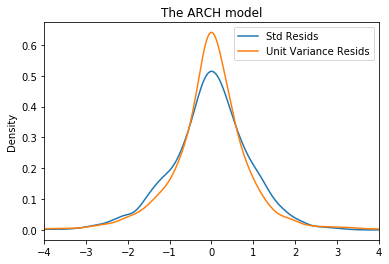

In [62]:
std_resid = res.resid / res.conditional_volatility
unit_var_resid = res.resid / res.resid.std()
df = pd.concat([std_resid, unit_var_resid],1)
df.columns = ['Std Resids', 'Unit Variance Resids']
subplot = df.plot(kind='kde', xlim=(-4,4),title='The ARCH model')

# 这里有一个网上画图的例子，我们取其精华，其实就是statsmodels.api 和statsmodels.tsa.api的应用

In [57]:
import os
import sys

import pandas as pd
import pandas_datareader.data as web
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
p = print

In [58]:
end = '2015-01-01'
start = '2007-01-01'
get_px = lambda x: web.DataReader(x, 'yahoo', start=start, end=end)['Adj Close']

symbols = ['SPY','TLT','MSFT']
# raw adjusted close prices
data = pd.DataFrame({sym:get_px(sym) for sym in symbols})
# log returns
lrets = np.log(data/data.shift(1)).dropna()

In [59]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
#         这里都在给画纸布局，没啥营养
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        
#   这一行是画acf
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
    
#   这一行画pacf
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
    
#   这一行画QQ图
        sm.qqplot(y, line='s', ax=qq_ax)
    
    
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

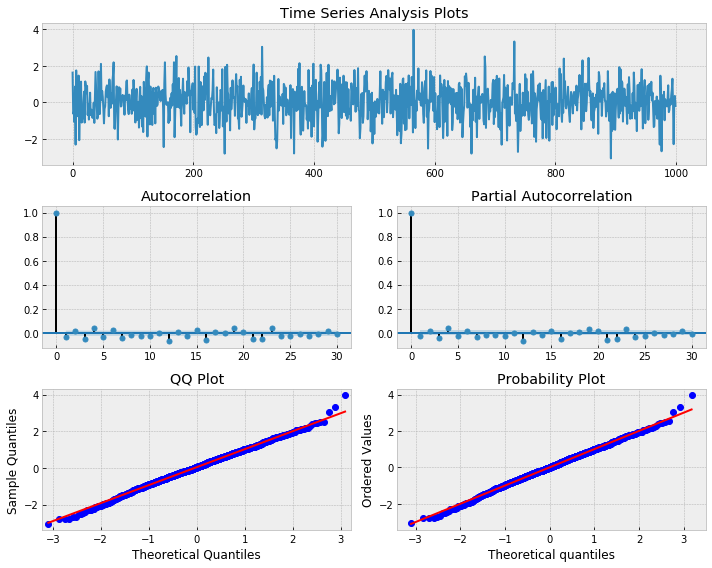

In [60]:
np.random.seed(1)

# plot of discrete white noise
randser = np.random.normal(size=1000)
tsplot(randser, lags=30)

In [61]:
res

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -5142.94
Distribution:                  Normal   AIC:                           10293.9
Method:            Maximum Likelihood   BIC:                           10318.5
                                        No. Observations:                 3521
Date:                Tue, Mar 12 2019   Df Residuals:                     3517
Time:                        23:57:12   Df Model:                            4
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0525  1.486e-02      3.533  4.105e-04 [2.